In [3]:
%matplotlib inline
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as td
import torch.nn.functional as F
import torchvision as tv
from torchvision import transforms
from utils import *
from PIL import Image
import nntools as nt
import matplotlib.pyplot as plt
from dataloader import *
import glob
#from test import *
from models import *
# from scipy.misc import imresize
from matplotlib.pyplot import imread
import torchvision.transforms
# im = imread(image.png)
import cv2

%matplotlib notebook

In [4]:
def target_transform (target, img_size = (224,224) ):
    
    object_to_idx = {'aeroplane': 0,'bicycle': 1,'bird': 2,'boat': 3,
                  'bottle': 4,'bus': 5,'car': 6,'cat': 7,
                  'chair': 8,'cow': 9,'diningtable': 10,'dog': 11,
                  'horse': 12,'motorbike': 13,'person': 14,'pottedplant': 15,
                  'sheep': 16,'sofa': 17,'train': 18,'tvmonitor': 19}
    
    
    h = target['annotation']['size']['height']
    h = float(h)
    w = target['annotation']['size']['width']
    w = float(w)

    if isinstance(target['annotation']['object'], list):
        boxes = [[object_to_idx[x['name']]] + [x['bndbox']['xmin'],x['bndbox']['ymin'],x['bndbox']['xmax'],x['bndbox']['ymax']] for x in target['annotation']['object']]
    elif isinstance(target['annotation']['object'], dict):
        x = target['annotation']['object']['bndbox']
        boxes = [object_to_idx[target['annotation']['object']['name']]] + [x['xmin'],x['ymin'],x['xmax'],x['ymax']]
    else:
        print('I do not know what happened')
    boxes = np.array(boxes).astype(np.float)
    boxes = boxes.reshape(-1, 5)
    xmin = boxes[:, 1] / w
    ymin = boxes[:, 2] / h
    xmax = boxes[:, 3] / w
    ymax = boxes[:, 4] / h
    x_center = (xmin + xmax) / 2 
    y_center = (ymin + ymax) / 2 
    box_w = (xmax - xmin) 
    box_h = (ymax - ymin) 
    boxes[:, 1] = x_center
    boxes[:, 2] = y_center
    boxes[:, 3] = box_w
    boxes[:, 4] = box_h
#     boxes[boxes > 1] = 1
#     boxes[boxes < 0] = 0
    targets = torch.zeros(len(boxes), 6)
    targets[:, 1:] = torch.Tensor(boxes)
    targets[targets != targets] = 0
    return targets

In [5]:
img_size = 224
transform = tv.transforms.Compose([
    tv.transforms.Resize((img_size, img_size)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [6]:
root='~/data/'

In [7]:
dataset_train = tv.datasets.VOCDetection(root, year='2012', image_set='train',transform = transform, 
                                   target_transform = target_transform, download = False)

dataset_val = tv.datasets.VOCDetection(root, year='2012', image_set='trainval',transform = transform, 
                                   target_transform = target_transform, download = False)

dataset_test = tv.datasets.VOCDetection(root, year='2012', image_set='val',transform = transform, 
                                   target_transform = target_transform, download = False)

dataset_origin = tv.datasets.VOCDetection(root, year='2012', image_set='val',transform = None, 
                                   target_transform = None, download = False)

In [8]:
def myimshow(image, ax=plt):
#     image = image.to('cpu').detach().numpy()
    image = np.moveaxis(image.numpy(), [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

<IPython.core.display.Javascript object>


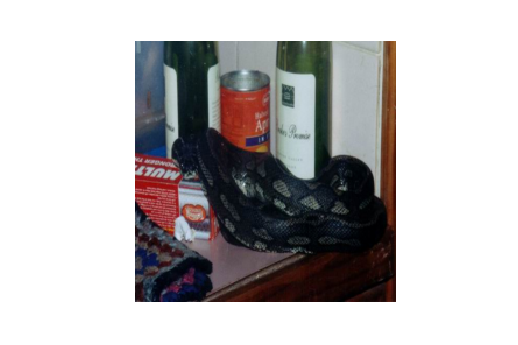

In [9]:
x, d = dataset_train[1]



y, f = dataset_val[2]

# myimshow(y)
# print(f)
z, e = dataset_test[8]

myimshow(x)

In [10]:
class VOCDataset(td.Dataset):
  
  def __init__(self, dataset, img_size = (224, 224)):
    super(VOCDataset, self).__init__()
    self.dataset = dataset
    self.img_size = img_size
  
  def collate_fn(self, batch):
    imgs, targets = list(zip(*batch))
    # Remove empty placeholder targets
    targets = [boxes for boxes in targets if boxes is not None]
    # Add sample index to targets
    for i, boxes in enumerate(targets):
        boxes[:, 0] = i
    targets = torch.cat(targets, 0)
    imgs = torch.stack([resize(img, img_size) for img in imgs])
    return imgs, targets

  def __getitem__(self, idx):
    x, d = self.dataset[idx]
    return x, d
  def __len__(self):
    return len(self.dataset)

In [11]:
trainset = VOCDataset(dataset_train)
valset = VOCDataset(dataset_val)
testset = VOCDataset(dataset_test)

In [12]:
print(len(trainset))
print(len(valset))
print(len(testset))
myimshow(trainset[1][0])
print(trainset.img_size)

5717
11540
5823
(224, 224)


In [13]:
object_to_idx = {'aeroplane': 0,'bicycle': 1,'bird': 2,'boat': 3,
              'bottle': 4,'bus': 5,'car': 6,'cat': 7,
              'chair': 8,'cow': 9,'diningtable': 10,'dog': 11,
              'horse': 12,'motorbike': 13,'person': 14,'pottedplant': 15,
              'sheep': 16,'sofa': 17,'train': 18,'tvmonitor': 19}


class_names = list(object_to_idx.keys())
print(class_names)

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [14]:

classes = ['person' , 'bird', 'cat', 'cow',
           'dog', 'horse', 'sheep', 'aeroplane',
           'bicycle', 'boat', 'bus', 'car',
           'motorbike', 'train', 'bottle', 'chair',
           'diningtable', 'pottedplant', 'sofa', 'tvmonitor']

In [15]:
Argument_Dict = {}
Argument_Dict['epochs'] = 100
Argument_Dict['batch_size'] = 8
Argument_Dict['model_def'] = 'config/yolov3-custom.cfg'
# Argument_Dict['pretrain_weights'] = True
Argument_Dict['pretrain_weights'] = 'checkpoints/yolov3_ckpt_87.pth' #train start
# Argument_Dict['pretrain_weights'] = 'checkpoints/yolov3_ckpt_59.pth' #test
#59 mAP is 0.55# 71 mAP 0.56
Argument_Dict['yolov3_weights'] = 'weights/yolov3.weights'
Argument_Dict['n_cpu'] = 4
Argument_Dict['gradient_accumulations'] = 2
Argument_Dict['evaluation_interval'] = 1
Argument_Dict['checkpoint_interval'] = 1
Argument_Dict['img_size'] = 224
Argument_Dict['conf_thres'] = 0.8 #object confidence threshold
Argument_Dict['nms_thres'] = 0.4 #iou thresshold for non-maximum suppression"

print(Argument_Dict)


{'epochs': 100, 'batch_size': 8, 'model_def': 'config/yolov3-custom.cfg', 'pretrain_weights': 'checkpoints/yolov3_ckpt_87.pth', 'yolov3_weights': 'weights/yolov3.weights', 'n_cpu': 4, 'gradient_accumulations': 2, 'evaluation_interval': 1, 'checkpoint_interval': 1, 'img_size': 224, 'conf_thres': 0.8, 'nms_thres': 0.4}


In [16]:
os.makedirs("output", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Darknet(Argument_Dict['model_def'],device=device).to(device)
model.apply(weights_init_normal)

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [19]:
model.load_darknet_weights(Argument_Dict['yolov3_weights'])
print('load darknet weights')

load darknet weights


In [20]:
dataloader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size= Argument_Dict['batch_size'],
    num_workers= Argument_Dict['n_cpu'],
    pin_memory= True,
    drop_last = True,
    shuffle = True,
    #collate_fn= trainset.collate_fn,
)

In [21]:
for i in dataloader:
    print(i)

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 79, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 79, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 55, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 2 and 1 in dimension 1 at /opt/conda/conda-bld/pytorch_1573049310284/work/aten/src/TH/generic/THTensor.cpp:689


In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [23]:
metrics = [
    "grid_size",
    "loss",
    "x",
    "y",
    "w",
    "h",
    "conf",
    "cls",
    "cls_acc",
    "recall50",
    "recall75",
    "precision",
    "conf_obj",
    "conf_noobj",
]

In [24]:
for epoch in range(72,Argument_Dict['epochs']):
    model.train()
    start_time = time.time()
    for batch_i, (imgs, targets) in enumerate(dataloader):
        batches_done = len(dataloader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
#         print(imgs.cpu().numpy().shape)
        targets = Variable(targets.to(device), requires_grad=False)

        loss, outputs = model(imgs, targets)
        loss.backward()

        if batches_done % Argument_Dict['gradient_accumulations']:
            # Accumulates gradient before each step
            optimizer.step()
            optimizer.zero_grad()

    if epoch % Argument_Dict['evaluation_interval'] == 0:
        log_str = "\n---- [Epoch %d/%d] ----\n" % (epoch, Argument_Dict['epochs'])
        log_str += f"\nTotal loss {loss.item()}"
        print(log_str)
        print("\n---- Evaluating Model ----")
        # Evaluate the model on the validation set
        precision, recall, AP, f1, ap_class = evaluate(
            model,
            dataset=valset, 
            iou_thres=0.5,
            conf_thres=0.5,
            nms_thres=0.5,
            img_size=Argument_Dict['img_size'],
            batch_size=Argument_Dict['batch_size'],
        )
        evaluation_metrics = [
            ("val_precision", precision.mean()),
            ("val_recall", recall.mean()),
            ("val_mAP", AP.mean()),
            ("val_f1", f1.mean()),
        ]
        
        ap_table = [["Index", "Class name", "AP"]]
        for i, c in enumerate(ap_class):
            ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
        print(AsciiTable(ap_table).table)
        print(f"---- mAP {AP.mean()}")

    if epoch % Argument_Dict['checkpoint_interval'] == 0:
        torch.save(model.state_dict(), f"checkpoints/yolov3_ckpt_%d.pth" % epoch)
#         Argument_Dict['pretrain_weights'] = 'checkpoints/yolov3_ckpt_%d.pth' % epoch

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 79, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 79, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 55, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 1 and 3 in dimension 1 at /opt/conda/conda-bld/pytorch_1573049310284/work/aten/src/TH/generic/THTensor.cpp:689


In [34]:
def make_batch(data, B=8):
    N = len(data) # get the size of x
    NB = N//B #compute the number of minibatch
    print(NB)
    ans=[]
    for l in range(NB):
        minibatch=[]
        for i in range(B):
        #minibatch_indices = shuffled_indices[] # get the minibatch
        minibatch=data[B*l:B*(l+1)] #pick up the x of minibatch
        ans.append(minibatch)
    return ans

In [35]:
dataloader=make_batch(trainset)

714


AttributeError: 'list' object has no attribute 'read'

In [37]:
trainset[1]

(tensor([[[-0.3176, -0.1686, -0.0667,  ...,  0.1608,  0.2314,  0.2392],
          [-0.2941, -0.2078, -0.0824,  ...,  0.1529,  0.2314,  0.2157],
          [-0.3098, -0.2392, -0.0745,  ...,  0.1529,  0.2235,  0.2078],
          ...,
          [-0.7882, -0.7725, -0.6784,  ..., -0.6314, -0.6706, -0.6627],
          [-0.6627, -0.6235, -0.4745,  ..., -0.6157, -0.6392, -0.6157],
          [-0.5529, -0.4510, -0.2549,  ..., -0.5451, -0.5529, -0.5294]],
 
         [[-0.1059,  0.0431,  0.1451,  ..., -0.2784, -0.2000, -0.1922],
          [-0.0902,  0.0039,  0.1373,  ..., -0.2784, -0.2000, -0.2157],
          [-0.1059, -0.0275,  0.1451,  ..., -0.2784, -0.2078, -0.2235],
          ...,
          [-0.8510, -0.8667, -0.8196,  ..., -0.8745, -0.9059, -0.8980],
          [-0.7176, -0.7020, -0.6000,  ..., -0.8588, -0.8902, -0.8667],
          [-0.6078, -0.5373, -0.3804,  ..., -0.7961, -0.8118, -0.7882]],
 
         [[ 0.0667,  0.1922,  0.2627,  ..., -0.6941, -0.6235, -0.6157],
          [ 0.0902,  0.1529,